**Fortaleza - CE**

In [40]:
# Importando módulos internos
import geocov19_functions_results as fresults

# Importando módulos externos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statistics import mean
from wordcloud import WordCloud

In [41]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [42]:
city = 'Fortaleza'
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'city':city, 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [43]:
len(df)

20509

In [44]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 10:17:46,user_location,Ceará,Fortaleza,RT @Miltonneves: Só piora. Isso não tá parecen...,-0.8693,pt
1,2020-02-02 11:16:39,user_location,Ceará,Fortaleza,RT @LeiaJaOnline: A notícia do falecimento foi...,-0.5994,pt
2,2020-02-02 11:44:30,user_location,Ceará,Fortaleza,RT @da_goiabeira: Passam a vida criticando a c...,-0.3612,pt
3,2020-02-02 12:14:23,user_location,Ceará,Fortaleza,RT @gazetadopovo: Primeira morte por coronavír...,-0.5994,pt
4,2020-02-02 12:58:19,user_location,Ceará,Fortaleza,RT @digital_explora: #CORONAVIRUS #CHINA/#WUHA...,0.0000,pt


Média total de sentimentos - Vader

In [45]:
df['score'].describe()

count    20509.000000
mean        -0.056980
std          0.432535
min         -0.997000
25%         -0.400500
50%          0.000000
75%          0.224700
max          0.998900
Name: score, dtype: float64

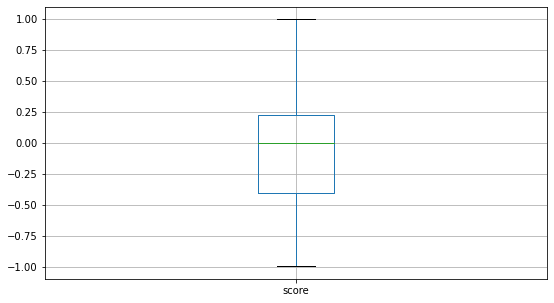

In [46]:
boxplot = df.boxplot(column=['score'], grid=True, figsize=(9, 5))

Análises por período

In [47]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [48]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "'+city+'"')
df_cases_city = df_cases_city.reset_index()
df_cases_city = df_cases_city.drop(columns=['index'])
df_cases_city.head()

,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,Fortaleza,2020-03-16,8,0.29777,0.0,0,CE,8,0
1,Fortaleza,2020-03-17,9,0.33499,0.0,0,CE,1,0
2,Fortaleza,2020-03-18,17,0.63277,0.0,0,CE,8,0
3,Fortaleza,2020-03-19,17,0.63277,0.0,0,CE,0,0
4,Fortaleza,2020-03-20,63,2.34496,0.0,0,CE,46,0


In [49]:
# Data do início das medidas restritivas
restriction_date = '2020-03-20'
print(restriction_date)

2020-03-20


In [50]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-03-16


In [51]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

2020-03-26


Média de sentimentos por dia

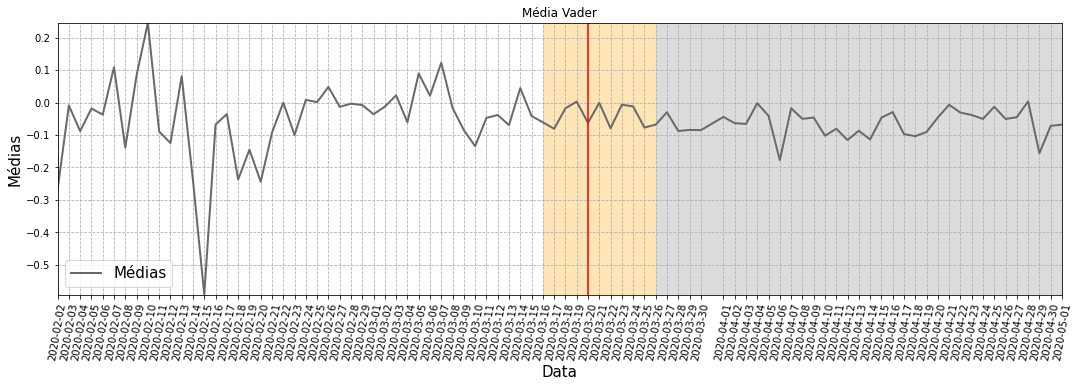

In [52]:
df_scores_city = fresults.building_dates_df(df, 'score')

x = df_scores_city.created_at
y = df_scores_city.score_mean

color = 'dimgrey'

label = 'Médias'
xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader'

fresults.generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, restriction_date, first_case_date, first_death_date)

**Análises por Período - Geral**

In [53]:
df_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case_date+' 00:00:00"')
print(len(df_periodo1))

df_periodo2 = df.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
print(len(df_periodo2))

df_periodo3 = df.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
print(len(df_periodo3))

2736
2601
15172


In [54]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

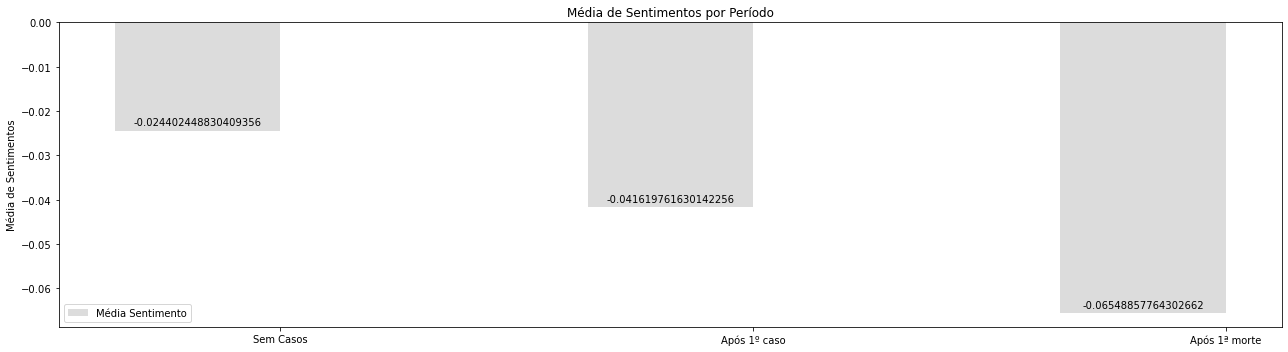

In [55]:
labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df_periodo1['score']), mean(df_periodo2['score']), mean(df_periodo3['score'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)

fig.tight_layout()

plt.show()

***
**Análises por Período - Detalhado**

**Tweets Negativos**

In [56]:
start = df['score'].describe()['min']
end = df['score'].describe()['25%']

print(start,end)

-0.997 -0.4005


Nuvem de palavras dos tweets mais negativos

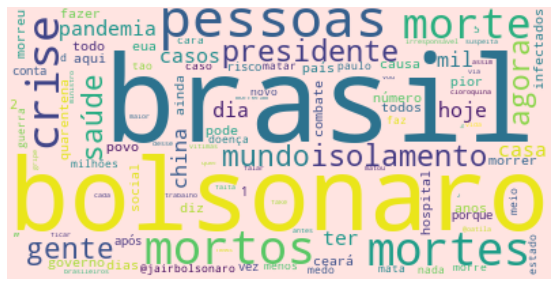

In [57]:
tokens_neg = fresults.return_tokens_from_interval(df, start, end)
fresults.generate_cloud_from_tokens(tokens_neg, 'mistyrose')

Palavras presentes nos tweets que mais influenciaram negativamente

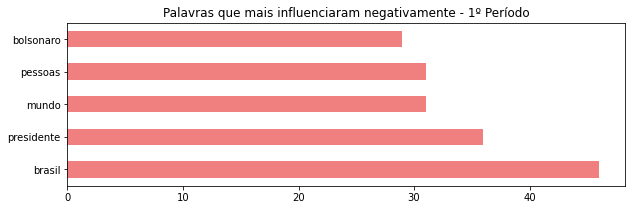

In [58]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
tokens_neg_1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
fresults.generate_bar_from_tokens(tokens_neg_1, 5, 'lightcoral', 10, 3, title)

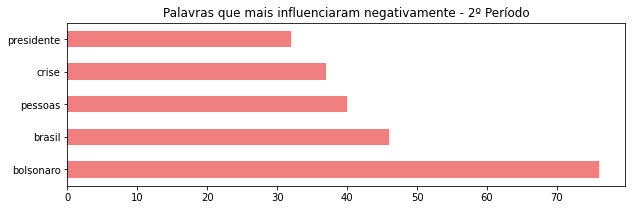

In [59]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
tokens_neg_2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
fresults.generate_bar_from_tokens(tokens_neg_2, 5, 'lightcoral', 10, 3, title)

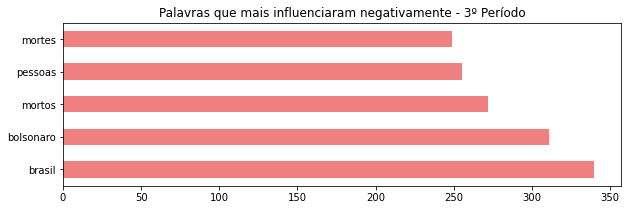

In [60]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
tokens_neg_3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
fresults.generate_bar_from_tokens(tokens_neg_3, 5, 'lightcoral', 10, 3, title)

Hashtags que mais influenciaram negativamente

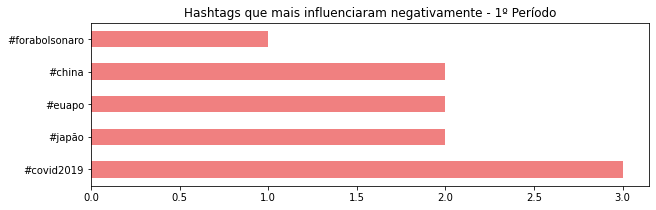

In [61]:
title = 'Hashtags que mais influenciaram negativamente - 1º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_1, 5, '#', 'lightcoral', 10, 3, title)

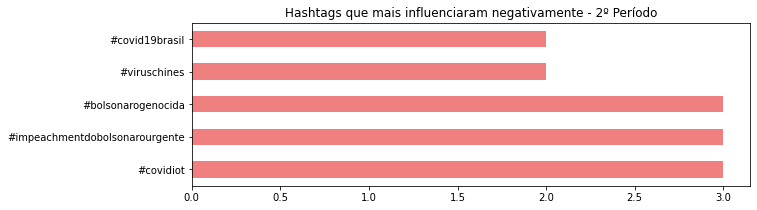

In [62]:
title = 'Hashtags que mais influenciaram negativamente - 2º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_2, 5, '#', 'lightcoral', 10, 3, title)

/home/mario/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/mario/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 21328 missing from current font.
  font.set_text(s, 0, flags=flags)


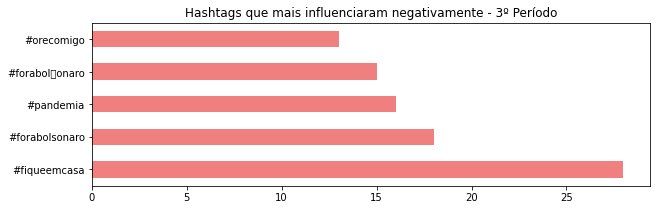

In [63]:
title = 'Hashtags que mais influenciaram negativamente - 3º Período'
fresults.generate_bar_from_filtered_tokens(tokens_neg_3, 5, '#', 'lightcoral', 10, 3, title)

**Tweets Positivos**

In [64]:
start = df['score'].describe()['75%']
end = df['score'].describe()['max']

print(start,end)

0.2247 0.9989


Nuvens de palavras que influenciaram positivamente

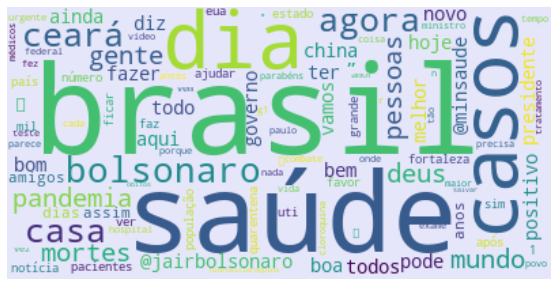

In [65]:
tokens_pos = fresults.return_tokens_from_interval(df, start, end)
fresults.generate_cloud_from_tokens(tokens_pos, 'lavender')

Palavras presentes nos tweets que mais influenciaram positivamente

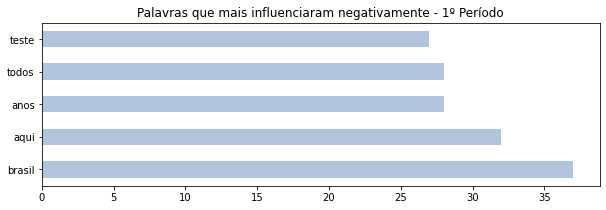

In [66]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
tokens_pos_1 = fresults.return_tokens_from_interval(df_periodo1, start, end)
fresults.generate_bar_from_tokens(tokens_pos_1, 5, 'lightsteelblue', 10, 3, title)

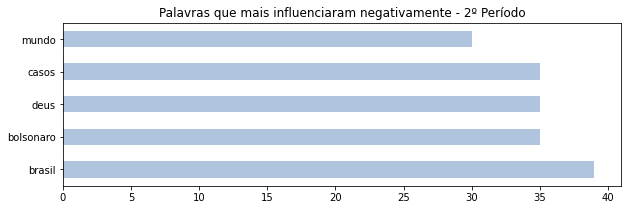

In [67]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
tokens_pos_2 = fresults.return_tokens_from_interval(df_periodo2, start, end)
fresults.generate_bar_from_tokens(tokens_pos_2, 5, 'lightsteelblue', 10, 3, title)

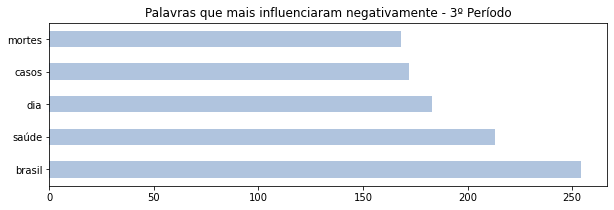

In [68]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
tokens_pos_3 = fresults.return_tokens_from_interval(df_periodo3, start, end)
fresults.generate_bar_from_tokens(tokens_pos_3, 5, 'lightsteelblue', 10, 3, title)

Hashtags que mais influenciaram positivamente

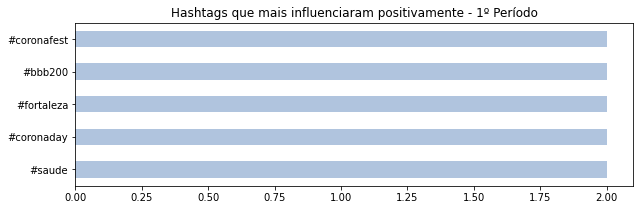

In [69]:
title = 'Hashtags que mais influenciaram positivamente - 1º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_1, 5, '#', 'lightsteelblue', 10, 3, title)

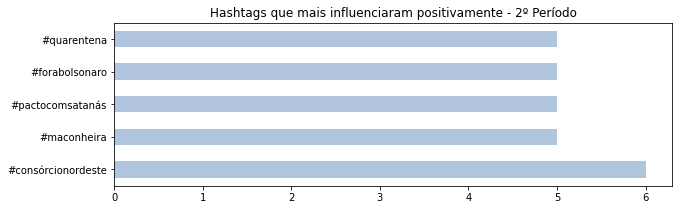

In [70]:
title = 'Hashtags que mais influenciaram positivamente - 2º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_2, 5, '#', 'lightsteelblue', 10, 3, title)

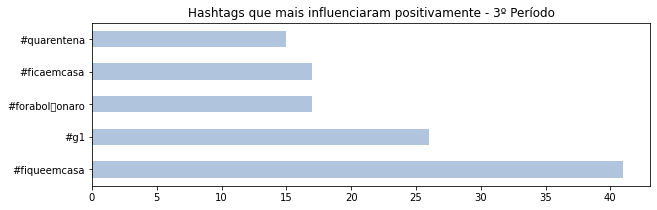

In [71]:
title = 'Hashtags que mais influenciaram positivamente - 3º Período'
fresults.generate_bar_from_filtered_tokens(tokens_pos_3, 5, '#', 'lightsteelblue', 10, 3, title)

***
Correlações com Casos de Covid

In [72]:
df_cases_city_2 = df_cases_city.query('date >= "'+first_case_date+'" and date < "'+first_death_date+'"')
df_cases_city_3 = df_cases_city.query('date >= "'+first_death_date+'" and date < "2020-05-02"')

df_scores_city_2 = df_scores_city.query('created_at >= "'+first_case_date+' 00:00:00" and created_at < "'+first_death_date+' 00:00:00"')
df_scores_city_3 = df_scores_city.query('created_at >= "'+first_death_date+' 00:00:00" and created_at < "2020-05-02 00:00:00"')

df_prepared_2 = fresults.prepare_data(df_cases_city_2, df_scores_city_2)
df_prepared_3 = fresults.prepare_data(df_cases_city_3, df_scores_city_3)

In [73]:
target_column = 'score_mean'
corr_matrix = df_prepared_2.corr()
corr_matrix[target_column].sort_values(ascending=False).head()

score_mean                                       1.000000
bad_news_pct                                     0.005455
new_confirmed_pct                                0.005455
last_available_confirmed_per_100k_inhabitants   -0.013516
last_bad_news                                   -0.013516
Name: score_mean, dtype: float64

In [78]:
target_column = 'score_mean'
corr_matrix = df_prepared_3.corr()
corr_matrix[target_column].sort_values(ascending=False)

score_mean                                           1.000000
last_available_confirmed_per_100k_inhabitants_pct    0.271938
last_available_confirmed_pct                         0.271938
last_bad_news_pct                                    0.245880
new_confirmed_pct                                    0.240918
bad_news_pct                                         0.197170
new_deaths_pct                                       0.104254
last_available_deaths_pct                           -0.254409
new_confirmed                                       -0.279627
last_available_death_rate                           -0.290215
bad_news                                            -0.296581
last_available_deaths                               -0.302086
last_available_confirmed_per_100k_inhabitants       -0.303065
last_available_confirmed                            -0.303065
last_bad_news                                       -0.303074
last_available_death_rate_pct                       -0.326815
new_deat